In [ ]:

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# New section

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Input, ZeroPadding2D, LeakyReLU, UpSampling2D

In [ ]:
#fn to parse the .cfg file

def parse_cfg(cfgfile):
  with open(cfgfile,'r') as file:
    
    #rstrip removes trailing spaces(sapces at last of line) or character if passed(eg. 's')
    lines=[line.rstrip('\n') for line in file if line !='\n' and line[0] != '#']
    #now lines contain all lines without any end spaces and empty lines

    holder={}  #temp dict to read data 
    blocks=[]  #list containing all layers info in dict format
  for line in lines:

    if line[0]=='[':
      line='type=' + line[1:-1].rstrip()
      #here we are storing layer type in 'type' key
      if len(holder) != 0:
        blocks.append(holder)
        holder={}
    key,value =line.split("=")
    holder[key.rstrip()] = value.lstrip()

  blocks.append(holder)
  print(len(blocks))
  return blocks 


  

In [ ]:
temp='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/cfg/yolov3.cfg'
parse_cfg(temp)

108


[{'angle': '0',
  'batch': '64',
  'burn_in': '1000',
  'channels': '3',
  'decay': '0.0005',
  'exposure': '1.5',
  'height': '608',
  'hue': '.1',
  'learning_rate': '0.001',
  'max_batches': '500200',
  'momentum': '0.9',
  'policy': 'steps',
  'saturation': '1.5',
  'scales': '.1,.1',
  'steps': '400000,450000',
  'subdivisions': '16',
  'type': 'net',
  'width': '608'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '32',
  'pad': '1',
  'size': '3',
  'stride': '1',
  'type': 'convolutional'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '64',
  'pad': '1',
  'size': '3',
  'stride': '2',
  'type': 'convolutional'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '32',
  'pad': '1',
  'size': '1',
  'stride': '1',
  'type': 'convolutional'},
 {'activation': 'leaky',
  'batch_normalize': '1',
  'filters': '64',
  'pad': '1',
  'size': '3',
  'stride': '1',
  'type': 'convolutional'},
 {'activation': 'linear', 'from': '-3', 'type'

In [ ]:
#yolo network fn.
def YOLOv3Net(cfgfile,model_size,num_classes):
  #storing return attributes from parse_cfg
  blocks=parse_cfg(cfgfile)

  outputs={}
  output_filters=[]
  filters=[]
  out_pred=[]
  scale=0

  #getting input for keras using input fn.(imported above)

  inputs=input_image=Input(shape=model_size)
  inputs=inputs/255.0

  #looping over various layer attributes (layers attributes start form index 1)
  for i,block in enumerate(blocks[1:]):

    #we 5 different layer types - 1>conv. layer , 2>upsample layer ,3>route layer
    # ,4>shortcut layer ,5>yolo layer

    # 1 >if conv layer its of 2 types conv layer followed by batch normalization layer 
    # have activation leaky relu otherwise uses linear activation

    if (block['type']=='convolutional'):

      activation=block['activation']
      filters=int(block['filters'])
      kernel_size=int(block['size'])
      strides=int(block['stride'])

      if strides>1:
        #now using keras
        #if stride >1 for our conv. layers then downsampling is performed
        inputs=ZeroPadding2D(((1,0),(1,0)))(inputs)

      #coming out of above if condition
      inputs=Conv2D(filters,kernel_size,strides=strides,
                    padding='valid' if strides > 1 else 'same',
                    name='conv_'+str(i),
                    use_bias=False if ('batch_normalize' in block) else True
                    )(inputs)

      if 'batch_normalize' in block:
        inputs=BatchNormalization(name='bnorm_'+str(i))(inputs)
        inputs=LeakyReLU(alpha=0.1,name='leaky_'+str(i))(inputs)

    #2 >Upsample layer it perform upsampling of previous layer output by a
    #factor of stride for it YOLO uses bilinear upsampling method

    elif (block['type']=='upsample'):
      stride=int(block['stride'])

      inputs=UpSampling2D(stride)(inputs)

    #3 >Route Layer(line 619,633 etc. of .cfg file) - it has only one attribute 'layers'
    # which can have 1 or 2 values -

    #1 >value say -4 then it will just output the feature map(output of a layer) of 4th 
    #   layer backward (backward direction is predicted from -ve sign) . 
    #2 >values say -1 and 61 then it will output concat of feature map of 1 layer backward 
    #   and 61th layer from beginning.

    elif (block['type']=='route'):

      block['layers']=block['layers'].split(',')
      start=int(block['layers'][0])

      if len(block['layers']) > 1:

        end=int(block['layers'][1])-i
        filters=output_filters[i+start] + output_filters[end]
        #here filters and output_filters are created above in this fn
        inputs=tf.concat( [ outputs[i+start],outputs[i+end] ],axis=-1 )

      else:
        filters=output_filters[i+start]
        inputs=outputs[i+start]

    #4 >shortcut layer - helps in adding skip connection .the important attribute is
    # 'from' which hold the layer position for adding its feature vector in previous
    # layer feature vector 

    elif block['type']=='shortcut':
      from_ = int(block['from'])
      inputs=outputs[i-1] + outputs[i+from_]

    #5 >yolo layer - here we are concerned with mask and anchor attribute ,all the 
    #   process of detection goes under this layer

    elif block['type']=='yolo':
      mask=block['mask'].split(',')
      mask=[int(x) for x in mask]

      anchors=block['anchors'].split(',')
      anchors=[int(a) for a in anchors]
      anchors=[(anchors[i],anchors[i+1]) for i in range(0,len(anchors),2)]
      anchors=[anchors[i] for i in mask]

      n_anchors=len(anchors)

      #now reshaping the output of yolov3->[None,total_anchors*grid_size*grid_size,5+classses]
      
      out_shape=inputs.get_shape().as_list()
      inputs=tf.reshape(inputs,[-1,n_anchors*out_shape[1]*out_shape[2],5+num_classes])

      #accessing box attributes i.e. center ,ht. ,width ,confidence
      box_centers=inputs[:,:,0:2]
      box_shapes=inputs[:,:,2:4]
      confidence=inputs[:,:,4:5]
      classes=inputs[:,:,5:5+num_classes]

      #refining bounding box attributes to lie in (0-1)
      box_centers=tf.sigmoid(box_centers)
      confidence=tf.sigmoid(confidence)
      classes=tf.sigmoid(classes)

      #hence converting box_shapes also
      anchors=tf.tile(anchors,[out_shape[1]*out_shape[2] ,1])
      box_shapes=tf.exp(box_shapes) * tf.cast(anchors,dtype=tf.float32)

      #now converting the absolute position of box centers into reap position using meshgrid

      #meshgrid
      x=tf.range(out_shape[1],dtype=tf.float32) 
      y=tf.range(out_shape[2],dtype=tf.float32)
      cx,cy = tf.meshgrid(x,y)

      cx=tf.reshape(cx ,(-1,1))
      cy=tf.reshape(cy ,(-1,1))
      cxy=tf.concat([cx,cy],axis=-1)

      cxy=tf.tile(cxy,[1,n_anchors])
      cxy=tf.reshape(cxy,[1,-1,2])

      strides=(input_image.shape[1] // out_shape[1] ,input_image.shape[2] // out_shape[2])

      box_centers=(box_centers+cxy)*strides #changed

      #concatinating all prediction details
      prediction=tf.concat([box_centers ,box_shapes , confidence ,classes],axis=-1)

      #now yolo do prediction across 3 dif. scales so we will concat all prediction together
      if scale:
        out_pred= tf.concat([out_pred,prediction],axis=1)
      else:
        out_pred=prediction
        scale=1

    #end of layers conditioning

    #keeping track of feature maps for every iteration for route and shortcut layers
    outputs[i]=inputs
    output_filters.append(filters)

    #end of loop

  model=Model(input_image,out_pred)
  model.summary

  return model


#Now we will be working on yolo v3 weights file that has pretrained wt. for every convolution layer(with batch normalization  and without batch normalization)

In [ ]:
import numpy as np

In [ ]:
#fn to load weights
def load_weights(model,cfgfile,weightfile):
  #where model argument contain model architecture
  #we will parse weightfile and cfgfile
  #as wts. are only for conv layers so we will only extract them

  #reading wt file
  fp=open(weightfile,'rb')
  np.fromfile(fp,dtype=np.int32,count=5)
  #as 1st 5 line are header info so we will skip them

  blocks=parse_cfg(cfgfile)
  #now looping over block to select only conv. layers
  for i,block in enumerate(blocks[1:]):

    if (block["type"]=="convolutional"):
      #selecting layer from model now
      conv_layer=model.get_layer('conv_'+str(i))  # not sure - i or i+1 
      print("layer: ",i+1,conv_layer)

      filters=conv_layer.filters
      k_size=conv_layer.kernel_size[0]
      in_dim=conv_layer.input_shape[-1]

      #if CONV. batch norm. layer then it has different params. 
      if "batch_normalize" in block:
        norm_layer=model.get_layer('bnorm_'+str(i))
        print("layer: ",i+1,norm_layer)

        size=np.prod(norm_layer.get_weights()[0].shape)

        #reading wt. for that particular layer  (batch_norm_weights=>bn_weights)
        bn_weights=np.fromfile(fp,dtype=np.float32,count=4*filters)
        #this will o/p [gamma,beta,mean,variance]

        #reshaping it to TF format [beta,gamma,mean,variance]
        bn_weights=bn_weights.reshape((4,filters))[[1,0,2,3]]
        
        #NOTE : Value of "W"(weight) will be read later as it common param in
        #both conv.layer type

      else:
        conv_bias=np.fromfile(fp,dtype=np.float32,count=filters)
        #because 2nd type has only biaas and weights

      #DARKNET shape = (out_dim,in_dim,height,width)
      conv_shape=(filters,in_dim,k_size,k_size)

      conv_weights=np.fromfile(fp,dtype=np.float32,count=np.product(conv_shape))
      #now we have weights also =>all params for a layer are extracted

      #reshaping darknet weights to TF shape =(ht,width,in_dom,out_dim)
      conv_weights=conv_weights.reshape(conv_shape).transpose([2,3,1,0])

      #every change and extraction is done 
      #Now we will set the weigths

      if "batch_normalize" in block:
        norm_layer.set_weights(bn_weights)
        conv_layer.set_weights([conv_weights])

      else :
        conv_layer.set_weights([conv_weights,conv_bias])

      #DONE
  
  #throwing exception if reading failed
  assert len(fp.read())==0, 'failed to read all data'
  fp.close()
  


In [ ]:
def main():
  weightfile='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/weights/yolov3.weights'
  cfgfile='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/cfg/yolov3.cfg'

  model_size=(416,416,3)
  num_classes=80

  #calling fn to get model layers ready
  model=YOLOv3Net(cfgfile,model_size,num_classes)

  #calling fn to load wts. of conv. layers
  load_weights(model,cfgfile,weightfile)

  try:
    model.save_weights('/content/drive/My Drive/PROJECTS/YOLOv3_TF2/weights/yolov3_weights.tf')
    print('\n the file (yolov3_weights.tf) is successfully stored')

  except IOError:
    print('\n unable to write the file')
    
main()

108
108
layer:  1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f12fdd06320>
layer:  1 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f13311e88d0>
layer:  2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f12f00c18d0>
layer:  2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f12f00c97b8>
layer:  3 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f12f00c9dd8>
layer:  3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f12f00714e0>
layer:  4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f12f0071a20>
layer:  4 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f12f008f128>
layer:  6 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f12f002bba8>
layer:  6 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f12f0030128>
layer:  7 <tensorflow.pytho

# now we will be working on utility for model where we will be creating imp. fn. (non_max_suppression , resize img ,output box , draw output )

In [ ]:
#we will not create fn from scratch but instead will leverage tf non_max_suppression fn.
def non_max_suppression(inputs,model_size,max_output_size,max_output_size_per_class,iou_threshold,confidence_threshold):

  bbox,confs,class_probs=tf.split(inputs,[4,1,-1],axis=-1)

  bbox=bbox/model_size[0]
  scores=confs*class_probs

  boxes ,scores ,classes ,valid_detections = tf.image.combined_non_max_suppression(
      boxes=tf.reshape(bbox,(tf.shape(bbox)[0],-1,1,4)),
      scores=tf.reshape(scores,(tf.shape(scores)[0],-1,tf.shape(scores)[-1])),
      max_output_size_per_class=max_output_size_per_class,
      max_total_size = max_output_size,
      iou_threshold = iou_threshold,
      score_threshold = confidence_threshold
  )

  return boxes ,scores ,classes ,valid_detections 

In [ ]:
#resizing image to fit the model input size requirement
def resize_image(inputs,modelsize):
  inputs=tf.image.resize(inputs,modelsize) 

  return inputs

In [ ]:
def load_class_names(file_name):
  with open(file_name,'r') as f:
    class_names= f.read().splitlines()
  return class_names

In [ ]:
#this fn will return the bound box of format (top_left_corner ,bottom_right_corner)
#then it apply non max suppression and returning fina bound boxes

def output_boxes(inputs,model_size,max_output_size,max_output_size_per_class,iou_threshold,confidence_threshold):

  center_x,center_y,width,height,confidence,classes=tf.split(inputs,[1,1,1,1,1,-1],axis=-1)

  top_left_x =center_x - width/2.0
  top_left_y =center_y - height/2.0
  bottom_right_x=center_x + width/2.0
  bottom_right_y =center_y + height/2.0

  inputs =tf.concat([top_left_x,top_left_y,bottom_right_x,bottom_right_y,confidence,classes],axis=-1)

  boxes_dicts = non_max_suppression(inputs ,model_size,max_output_size,max_output_size_per_class,iou_threshold,confidence_threshold)

  return boxes_dicts

In [ ]:
#this fn will draw bounding boxes arround obj.

def draw_outputs(img,boxes,objectness,classes,nums,class_names):
  boxes,objectness,classes,nums = boxes[0],objectness[0],classes[0],nums[0]
  boxes=np.array(boxes)

  for i in range(nums):
    x1y1 =tuple( (boxes[i,0:2]*[img.shape[1],img.shape[0]]).astype(np.int32) )
    x2y2 =tuple( (boxes[i,2:4]*[img.shape[1],img.shape[0]]).astype(np.int32) )

    img=cv2.rectangle(img, (x1y1) ,(x2y2) ,(255,0,0),2)

    img=cv2.putText(img ,'{}{:.4f}'.format(class_names[int(classes[i])],objectness[i]),(x1y1),cv2.FONT_HERSHEY_PLAIN,1,(0,0,255),2)


  return img

##Fn to create bounding boxes around images in img folder

In [ ]:
#physical_devices=tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0,"GPU not available"

#tf.config.experimental.set_memory_growth(physical_devices[0],True)

model_size=(416,416,3)
num_classes=80
class_name='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/data/coco.names'
max_output_size=40
max_output_size_per_class=20
iou_threshold=0.5
confidence_threshold=0.5

cfgfile='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/cfg/yolov3.cfg'
weightfile='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/weights/yolov3_weights.tf'
img_path='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/img/test2.jpg'





108


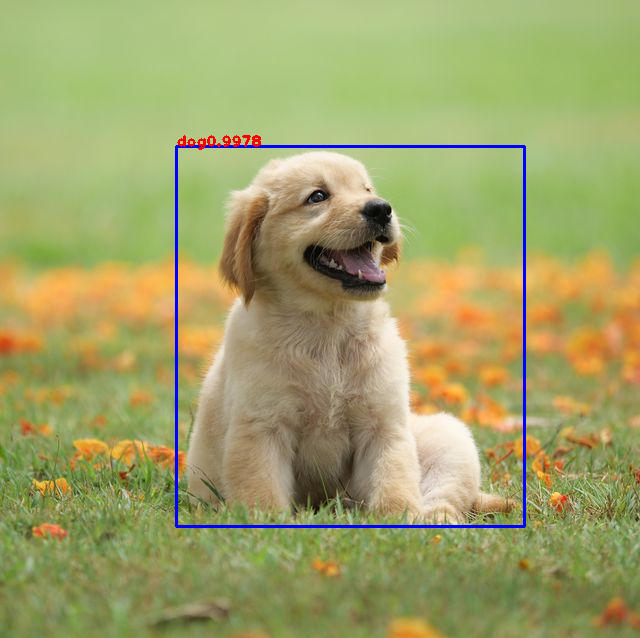

True

In [ ]:
# this fn will perform object detection
#def predictor():

model=YOLOv3Net(cfgfile,model_size,num_classes)
model.load_weights(weightfile)

class_names=load_class_names(class_name)

image=cv2.imread(img_path)
image=np.array(image)
image=tf.expand_dims(image,0)

resized_frame=resize_image(image, (model_size[0],model_size[1]) )
pred=model.predict(resized_frame)
 
boxes ,scores ,classes, nums = output_boxes(pred,model_size,max_output_size=max_output_size,
                                               max_output_size_per_class=max_output_size_per_class,
                                               iou_threshold=iou_threshold,confidence_threshold=confidence_threshold)
   
image=np.squeeze(image)
img=draw_outputs(image,boxes,scores,classes,nums,class_names)
 
win_name ="IMG DETECTION"
cv2_imshow(img)
cv2.waitKey(0) 

cv2.destroyAllWindows()

cv2.imwrite('test.jpg',img)



In [ ]:
#physical_devices=tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0,"GPU not available"

#tf.config.experimental.set_memory_growth(physical_devices[0],True)

model_size=(416,416,3)
num_classes=80
class_name='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/data/coco.names'
max_output_size=40
max_output_size_per_class=20
iou_threshold=0.5
confidence_threshold=0.5

cfgfile='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/cfg/yolov3.cfg'
weightfile='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/weights/yolov3_weights.tf'
img_path='/content/drive/My Drive/PROJECTS/YOLOv3_TF2/img/test.jpg'

108


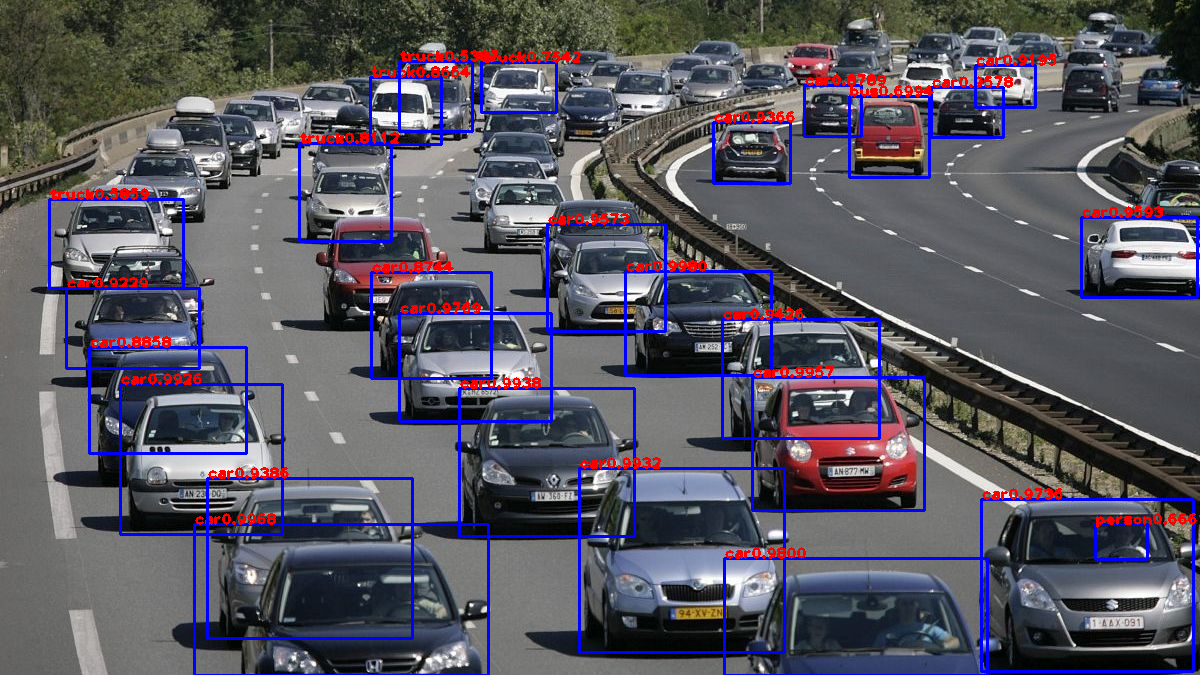

True

In [ ]:
# this fn will perform object detection
#def predictor():

model=YOLOv3Net(cfgfile,model_size,num_classes)
model.load_weights(weightfile)

class_names=load_class_names(class_name)

image=cv2.imread(img_path)
image=np.array(image)
image=tf.expand_dims(image,0)

resized_frame=resize_image(image, (model_size[0],model_size[1]) )
pred=model.predict(resized_frame)
 
boxes ,scores ,classes, nums = output_boxes(pred,model_size,max_output_size=max_output_size,
                                               max_output_size_per_class=max_output_size_per_class,
                                               iou_threshold=iou_threshold,confidence_threshold=confidence_threshold)
   
image=np.squeeze(image)
img=draw_outputs(image,boxes,scores,classes,nums,class_names)
 
win_name ="IMG DETECTION"
cv2_imshow(img)
cv2.waitKey(0) 

cv2.destroyAllWindows()

cv2.imwrite('test.jpg',img)